# Exploratory Data Analysis
In this notebook, we will explore ways to normalize the data so that the model can train and read it in a uniform way. This notebook is also used to find additional features and to validate preprocessing steps.

## Normalization
First we will start by finding ways to normalize our hand data. To do this, we will ahve to import the necessary libraries to examine the data, and also create a function so we can easily visualize our samples.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

FILE_PATH = "C:/Users/natec/Documents/Coding/finger-jams"

In [ ]:
def plot_hand_3d(sample: pd.DataFrame, title="Hand Landmarks", elev=None, azim=None, roll=None):
    # Convert coords to numpy
    coords = sample.to_numpy()

    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Set points
    xs, ys, zs = coords[:, 0], coords[:, 1], coords[:, 2]

    # Plot points
    ax.scatter(xs, ys, zs, c='blue')

    # Connect the dots with known hand skeleton connections 
    mp_hands_connections = [
        (0,1), (1,2), (2,3), (3,4),     # Thumb
        (0,5), (5,6), (6,7), (7,8),     # Index
        (0,9), (9,10), (10,11), (11,12),# Middle
        (0,13), (13,14), (14,15), (15,16), # Ring
        (0,17), (17,18), (18,19), (19,20)  # Pinky
    ]

    for i, j in mp_hands_connections:
        ax.plot([xs[i], xs[j]], [ys[i], ys[j]], [zs[i], zs[j]], c='gray')

    # Set plot settings
    ax.view_init(elev=elev, azim=azim, roll=roll, vertical_axis='y')
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1, 1.5, 1])
    plt.show()

Lets take a look at one sample that we took and see what the coordinates look like

           x         y             z
0   0.506479  0.418282  7.498032e-09
1   0.541585  0.414514 -1.017613e-02
2   0.577894  0.392317 -2.816364e-02
3   0.595410  0.357983 -4.906380e-02
4   0.587373  0.319151 -7.047319e-02
5   0.580153  0.281190 -2.160863e-02
6   0.606431  0.214094 -4.711664e-02
7   0.620687  0.169834 -6.890222e-02
8   0.632790  0.132225 -8.471663e-02
9   0.555309  0.258400 -3.251788e-02
10  0.569721  0.262182 -6.704819e-02
11  0.554559  0.330044 -8.028139e-02
12  0.542531  0.372318 -8.349641e-02
13  0.528348  0.249321 -4.449092e-02
14  0.541893  0.274129 -7.326104e-02
15  0.530382  0.333211 -7.650021e-02
16  0.522138  0.364112 -7.474037e-02
17  0.501498  0.251423 -5.889606e-02
18  0.516488  0.272629 -7.269422e-02
19  0.512837  0.320456 -7.258553e-02
20  0.508071  0.344592 -7.113919e-02


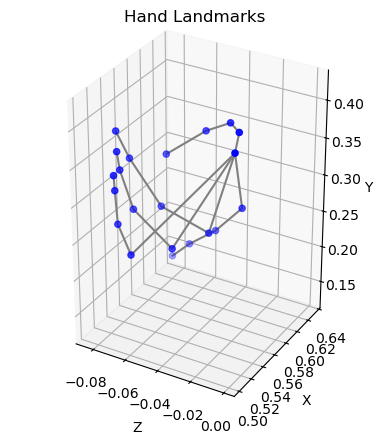

In [ ]:
# Load Data
data = np.load(f"{FILE_PATH}/Datasets/raw/pos_1_data.npz")
coords = data['coords']
labels = data['labels']

# Convert a sample to a panda
sample_num = 1
sample = pd.DataFrame(coords[sample_num], columns=['x','y','z'])
print(sample)

plot_hand_3d(sample)

Each point represents a hand landmark that the Mediapipe model recognizes. When Mediapipe returns the coordinates for each hand landmark, the coordinates are dependent on the hands position within the camera. Lets normalize it by placing the origin of the coordinates space always at landmark 0, which is the wrist.

           x         y         z
0   0.000000  0.000000  0.000000
1   0.035106 -0.003769 -0.010176
2   0.071416 -0.025965 -0.028164
3   0.088931 -0.060299 -0.049064
4   0.080895 -0.099131 -0.070473
5   0.073674 -0.137092 -0.021609
6   0.099952 -0.204188 -0.047117
7   0.114208 -0.248448 -0.068902
8   0.126311 -0.286058 -0.084717
9   0.048830 -0.159882 -0.032518
10  0.063242 -0.156100 -0.067048
11  0.048080 -0.088238 -0.080281
12  0.036052 -0.045965 -0.083496
13  0.021870 -0.168961 -0.044491
14  0.035414 -0.144154 -0.073261
15  0.023903 -0.085072 -0.076500
16  0.015660 -0.054171 -0.074740
17 -0.004981 -0.166859 -0.058896
18  0.010009 -0.145654 -0.072694
19  0.006358 -0.097826 -0.072586
20  0.001592 -0.073690 -0.071139


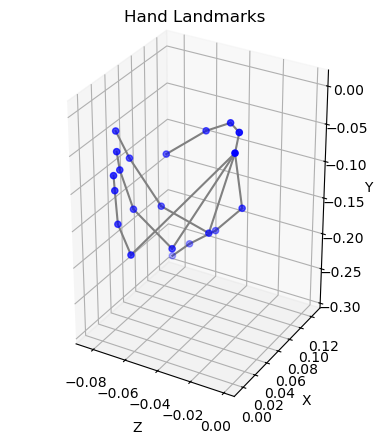

In [ ]:
def normalize_position(sample: pd.DataFrame):
    # Set origin as the wrist
    origin = sample.loc[0]
    
    # Center landmarks around wrist
    return sample - origin

# Normalizing sample position
norm_p_sample = normalize_position(sample)
print(norm_p_sample)

plot_hand_3d(norm_p_sample)

While we have normalized the position of the coordinates, the scale of the coordinates will vary greatly for two reasons. First, if your hand is close to the screen, the range of the coordinates will be much, much larger then if you are standing 3 feet away from the camera. Second, it is important to normalize the scale as people have different hand sizes. To normalize the scale, lets set the length between the wrist, landmark 0, and the base of the middle finger, landmark 9, to be exactly one for any inputted sample. 

           x         y         z
0   0.000000  0.000000  0.000000
1   0.206137 -0.022129 -0.059752
2   0.419338 -0.152460 -0.165371
3   0.522184 -0.354062 -0.288092
4   0.474996 -0.582076 -0.413804
5   0.432601 -0.804978 -0.126881
6   0.586899 -1.198950 -0.276659
7   0.670606 -1.458835 -0.404579
8   0.741672 -1.679672 -0.497438
9   0.286721 -0.938794 -0.190938
10  0.371344 -0.916589 -0.393693
11  0.282317 -0.518114 -0.471395
12  0.211692 -0.269895 -0.490273
13  0.128414 -0.992105 -0.261241
14  0.207946 -0.846440 -0.430173
15  0.140353 -0.499522 -0.449193
16  0.091951 -0.318079 -0.438860
17 -0.029247 -0.979762 -0.345825
18  0.058771 -0.855247 -0.426845
19  0.037335 -0.574414 -0.426207
20  0.009350 -0.432692 -0.417714
Distance to landmark 9 is 0.9999999403953552


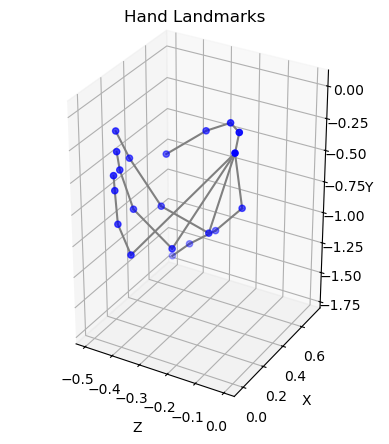

In [ ]:
def normalize_scale(sample: pd.DataFrame):
    # Get the middle finger base coordinate
    mid_finger_base = sample.loc[9]

    # Get the norm of the vector from the wrist
    scale = np.linalg.norm(mid_finger_base[['x','y','z']].values)

    # Scale the sample 
    return sample/scale

# Normalizing sample's scale
norm_ps_sample = normalize_scale(norm_p_sample)
print(norm_ps_sample)

distance_to_lm9 = np.linalg.norm(norm_ps_sample.loc[9].to_numpy())
print(f"Distance to landmark 9 is {distance_to_lm9}")

plot_hand_3d(norm_ps_sample)

We use the pythagorean theorem to calculate the distance from the wrist to the base of the middle finger. Our calculations confirm that it is almost exactly equal to a length of one. 

However, we still have more normalization to do. The rotation of the hand is still being taken into account. It will be hard for the model to learn patterns if the hand could be tilted to the left or right. Even if the same gesture was being made, the coordinates would differ greatly. Lets normalize the rotation so that the vector from the wrist to the middle finger (0-9) is aligned with the y-axis.

               x         y             z
0   0.000000e+00  0.000000  0.000000e+00
1  -1.178356e-01  0.091287  1.559934e-01
2  -2.480967e-01  0.294938  2.790986e-01
3  -3.353524e-01  0.537120  2.829727e-01
4  -3.662264e-01  0.761652  1.463972e-01
5  -3.113021e-02  0.903970  1.819343e-01
6  -1.050856e-01  1.346668  1.841595e-01
7  -1.737130e-01  1.639072  1.576838e-01
8  -2.178385e-01  1.884498  1.415357e-01
9  -4.020337e-08  1.000000  2.677291e-08
10 -2.167587e-01  1.042131 -2.053373e-03
11 -3.699617e-01  0.657356 -3.701873e-02
12 -4.337822e-01  0.407684 -6.042776e-02
13  6.725337e-03  1.018082 -1.802046e-01
14 -2.134324e-01  0.936392 -1.495620e-01
15 -3.067192e-01  0.594959 -1.514711e-01
16 -3.328910e-01  0.408770 -1.559419e-01
17 -1.836910e-02  0.977440 -3.530695e-01
18 -1.567415e-01  0.901253 -2.833274e-01
19 -2.293358e-01  0.631341 -2.486209e-01
20 -2.527713e-01  0.488647 -2.431582e-01


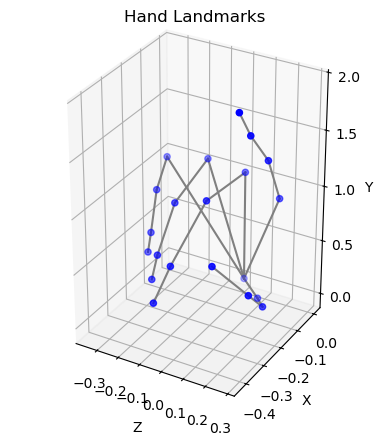

In [ ]:
def normalize_rotation(sample: pd.DataFrame):
    # Get vector from wrist to middle_finger_base
    v = sample.loc[9].to_numpy() - sample.loc[0].to_numpy()

    # Get vector where hand should be aligned
    target = np.array([0, 1, 0])

    # Get normalized axis of rotation between v and target
    rot_axis = np.cross(v, target)
    rot_axis = rot_axis/np.linalg.norm(rot_axis)

    # Get angle between v and target
    v_len = np.linalg.norm(v)
    target_len = np.linalg.norm(target)
    angle = np.arccos(np.dot(v, target) / (v_len * target_len))

    # Rodrigues rotation matrix
    K = np.array([
        [0, -rot_axis[2], rot_axis[1]],
        [rot_axis[2], 0, -rot_axis[0]],
        [-rot_axis[1], rot_axis[0], 0]
    ])
    I = np.identity(3)
    rot_matrix = I + np.sin(angle) * K + (1-np.cos(angle)) * (K @ K)
    
    # Convert the sample to a numpy array
    sample_matrix = sample.to_numpy()

    # Get the rotated landmarks
    rot_lms = sample_matrix @ rot_matrix.T
    
    return pd.DataFrame(rot_lms, columns=['x','y','z'], index=sample.index)

# Rotating the sample
norm_psr_sample = normalize_rotation(norm_ps_sample)
print(norm_psr_sample)
plot_hand_3d(norm_psr_sample)

Great! This plot makes our normalization steps so far very clear. The wrist is clearly at the origin, the vector from 0-9 is clearly one, and the vector clearly looks aligned with the y-axis. 

There is another issue though: even though it is rotated to be aligned with the y-axis, the hand still rotate around the y-axis. We need to make a vector in the hand perfectly aligned with the X-Y plane. Lets use the vector from 0-1 which is from the wrist to the thumb. While the vector 0-9 must be aligned with the y-axis, the hand must be roatated around the axis till the vector 0-1 is soley in the X-Y plane, meaning it should have no z-value

               x         y             z
0   0.000000e+00  0.000000  0.000000e+00
1   1.954972e-01  0.091287  1.387779e-17
2   3.722414e-01  0.294938  2.973796e-02
3   4.279259e-01  0.537120  9.702692e-02
4   3.375572e-01  0.761652  2.039829e-01
5   1.639348e-01  0.903970 -8.482081e-02
6   2.102868e-01  1.346668 -2.715074e-02
7   2.305261e-01  1.639072  4.356744e-02
8   2.442376e-01  1.884498  8.850985e-02
9   4.559546e-08  1.000000  1.594220e-08
10  1.290125e-01  1.042131  1.741962e-01
11  1.934553e-01  0.657356  3.175170e-01
12  2.132443e-01  0.407684  3.825512e-01
13 -1.478446e-01  1.018082  1.032516e-01
14  9.305767e-03  0.936392  2.604526e-01
15  6.401090e-02  0.594959  3.360399e-01
16  7.621855e-02  0.408770  3.596179e-01
17 -2.706533e-01  0.977440  2.274693e-01
18 -1.316001e-01  0.901253  2.958441e-01
19 -6.015069e-02  0.631341  3.328501e-01
20 -4.166609e-02  0.488647  3.482573e-01


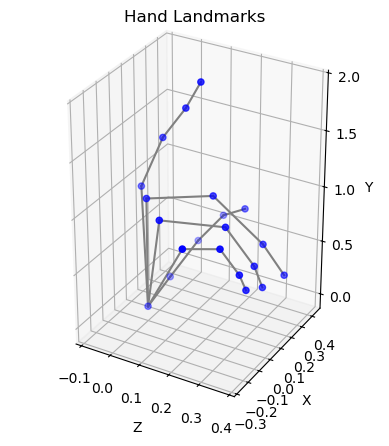

In [ ]:
def normalize_alignment(sample: pd.DataFrame): #Rotates vector from 0-1 to positive right axis
    # Get vector from wrist to thumb base
    v = sample.loc[1].to_numpy() - sample.loc[0].to_numpy()

    # Get the projection of the vector on the x-z plane
    v_proj = np.array([v[0], 0, v[2]])

    # Get the angle between the projection and the x-axis
    theta = np.arctan2(v_proj[2], v_proj[0])

    # Form angle rotation matrix
    rot_matrix = np.array([
        [np.cos(-theta), 0, np.sin(-theta)],
        [0, 1, 0],
        [-np.sin(-theta), 0, np.cos(-theta)]
    ])
    
    # Apply rotation matrix and return
    rotated = sample.to_numpy() @ rot_matrix
    return pd.DataFrame(rotated, columns=['x','y','z'], index=sample.index)

# Align sample with the X-Y plane
norm_psar_sample = normalize_alignment(norm_psr_sample)
print(norm_psar_sample)
plot_hand_3d(norm_psar_sample)

In [58]:
def normalize_psar(sample: pd.DataFrame):
    sample = normalize_position(sample)
    sample = normalize_scale(sample)
    sample = normalize_alignment(sample)
    sample = normalize_rotation(sample)
    return sample

We have one more step we need to do before we finish our preprocessing pipeline. If we grab coordinates for the left hand, and send it through our pipeline, it will process exactly the same. But since its the left hand, after normalization, the scale, size, and the rotation will be the same and the thumbs will be in the same plane and direction. However the palm will be facing the opposite direction. Lets use a matrix to flip the coordinates across the X-axis

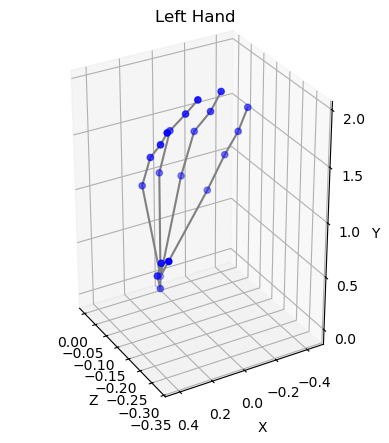

In [ ]:
# Now we need to figure out how to flip the left hand
test_data = np.load(f"{FILE_PATH}/datasets/test_data/left_hand_data.npz")
data = test_data['coords'][1] # Get a snapshot of a left hand
left_hand = pd.DataFrame(data, columns=['x','y','z'])
plot_hand_3d(normalize_psar(left_hand), title="Left Hand", azim=150)

In [ ]:
def normalize_left(left_df: pd.DataFrame):
    # Form matrix to flip array across x-axis
    flip_x = np.array([
        [-1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])
    # Apply matrix and return
    right_df = pd.DataFrame((left_df.to_numpy() @ flip_x.T), columns=['x', 'y', 'z'])
    return right_df

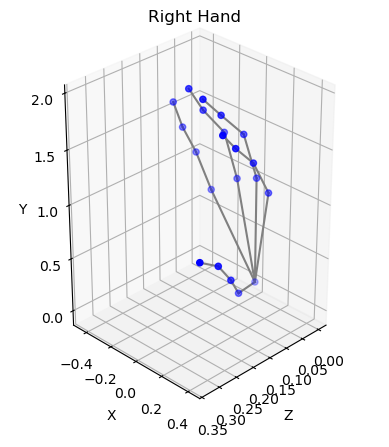

In [64]:
right_hand = normalize_psar(normalize_left(left_hand))
plot_hand_3d(right_hand, title="Right Hand", azim = 45)

## Feature Engineering

One issue I'm facing while testing the model is that even with normalization, my model has a hard time distinugishing between positions 5 and 6 because the only difference is whether the thumb is tucked into the palm or fully extended. I can gather more samples to fix this issue, but another solution is to create your own features so that the model can distinugish the classes easily. Since the model needs more features on the thumb, lets calculate the angle the thumb is extended from vector 0-9. If we just used the angle, there would be a large difference between 359 degrees and 1 degree even though they essentially the same angle. So lets grab the sin and cosine of the angle and add it as a feature for our model to train on!

In [ ]:
def compute_thumb_angle(sample: np.ndarray):
    # Get vectors
    v_thumb  = sample[4] - sample[1]
    v_palm = sample[9]- sample[0]

    # Get norms
    norm_thumb = np.linalg.norm(v_thumb)
    norm_palm = np.linalg.norm(v_palm)

    # Get denominator and return if 0
    denom = norm_thumb * norm_palm
    if denom == 0:
        return [0, 1]
    
    # Calculate the angle between the two vectors
    angle = np.arccos(np.clip(np.dot(v_thumb, v_palm) / denom, -1.0, 1.0))

    # Return the sin and cosine of the angles
    return [np.sin(angle), np.cos(angle)]

# Compute the thumb angle of the sample
sin, cos = compute_thumb_angle(sample.to_numpy())
print(sin)
print(cos)

NameError: name 'np' is not defined